<a href="https://colab.research.google.com/github/salomonBKS/projet_deep/blob/main/Conducteur_Distrait.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Détection de conducteur distrait : State Farm

https://www.kaggle.com/c/state-farm-distracted-driver-detection

In [ ]:
!pip install fastai==2.5.3

### Question 1. 
Utilisez le “seed number” 2021 dans tout votre travail.

In [ ]:
# voir chargement des données 

### Question 2. 
Chargez les images avec la librairie fastai et en visualisez un lot (batch)

In [3]:
import pandas as pd 

path = "drive/MyDrive/conducteur/"
df = pd.read_csv(path + 'driver_imgs_list.csv')
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [4]:
df.sample(10)

,subject,classname,img
587,p002,c7,img_4463.jpg
11745,p042,c6,img_98977.jpg
21560,p075,c9,img_14657.jpg
2614,p015,c2,img_97977.jpg
21663,p081,c0,img_36854.jpg
15604,p051,c2,img_43410.jpg
3231,p015,c8,img_63083.jpg
11005,p041,c3,img_53600.jpg
7791,p024,c7,img_6061.jpg
21143,p075,c4,img_88421.jpg


In [5]:
df = df.sort_values("subject")

In [6]:
user_train = ['p035', 'p022', 'p016', 'p052', 'p014',
              'p002', 'p015', 'p041', 'p026', 'p021',
              'p039', 'p050', 'p051', 'p047', 'p012',
              'p045', 'p049', 'p024', 'p042']

In [7]:
user_test = [ i for i in set(df.subject) if i not in user_train ]

In [8]:
def filter_rows_by_values(df, col, values):
    return df[df[col].isin(values)]

df_train  = filter_rows_by_values(df, "subject", user_train)
df_test =  filter_rows_by_values(df, "subject", user_test)

In [9]:
df_train.shape, df_test.shape

((16984, 3), (5440, 3))

In [ ]:
df_train["is_valid"] = False

In [11]:
df_train.head()

,subject,classname,img,is_valid
0,p002,c0,img_44733.jpg,False
479,p002,c6,img_78546.jpg,False
480,p002,c6,img_98318.jpg,False
481,p002,c6,img_98248.jpg,False
482,p002,c6,img_508.jpg,False


In [ ]:
df_test["is_valid"] = True

In [13]:
df_test.head()

,subject,classname,img,is_valid
17516,p056,c6,img_68382.jpg,True
17515,p056,c6,img_16719.jpg,True
17514,p056,c6,img_23145.jpg,True
17509,p056,c6,img_71713.jpg,True
17512,p056,c6,img_100565.jpg,True


In [14]:
df = pd.concat([df_train, df_test ], ignore_index=True)

In [15]:
df.sample(10)

,subject,classname,img,is_valid
9449,p035,c5,img_98053.jpg,False
527,p002,c0,img_59000.jpg,False
9770,p035,c2,img_88757.jpg,False
2836,p015,c7,img_35412.jpg,False
576,p002,c3,img_11982.jpg,False
2165,p014,c0,img_55385.jpg,False
7498,p024,c1,img_7162.jpg,False
7318,p024,c7,img_56064.jpg,False
5992,p022,c9,img_31028.jpg,False
8150,p026,c6,img_12892.jpg,False


In [16]:
df.isnull().sum()

subject      0
classname    0
img          0
is_valid     0
dtype: int64

In [17]:
df.shape

(22424, 4)

In [ ]:
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import Resize, aug_transforms

path_data = "drive/MyDrive/conducteur/"
dls = ImageDataLoaders.from_df(df[["img", "classname", "is_valid"]], path_data, folder='my_train', valid_col='is_valid', label_delim=' ', item_tfms=Resize(460), batch_tfms=aug_transforms(size=224), seed=2021)

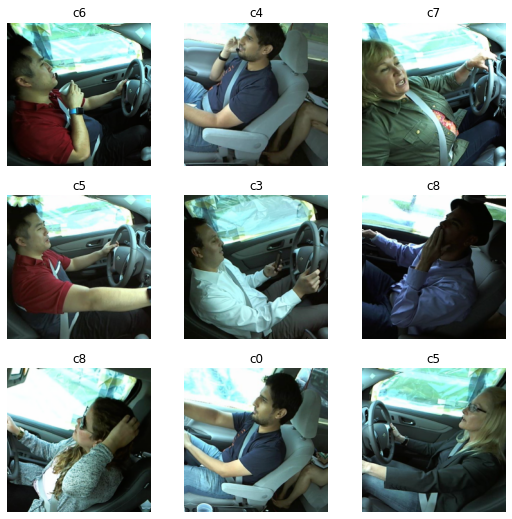

In [19]:
dls.show_batch()

### Question 3.
Déterminez les différentes strates ou aspects de ces images puis construisez un ensemble de validation équilibré entre ces dernières en vous basant sur les infos de ce dataset mentionné à la fin du notebook “lesson1_cnn”. Le ratio de l’ensemble de validation doit être de 25%.


La strategie de validation en local se deroule comme suite : 

1.   Pour une strate de 25% on obtient 16818 echantillons en train contre 5606 sauf que les individus d'au moins une classe se trouve à la fois en train et test. Nous trions le dataFrame sur la colonne subject, et selectionnons les 26 premiers sujet de sorte à obtenir la plus petite marge d'erreur vus qu'on ne peu effectuer cette stratification de facon exacte. Ceci nous permet d'obtenir deux (2) dataFrames (Apprentissage - Validation) de respectivement **16984** et **5440**.

2.   Nous créons une colonne Booleens **is_valid** pour chaque dataframe.
Cette colonne **is_valid** indique si l'observation est dans le jeu de validation ou non. On utilise la fonction from_df de ImageDataLoaders. Nous avons dans le repertoire "my_train" toutes les images (toutes classes confondu) que nous passons à la fonction.


In [ ]:
# voir question 2


### Question 4. 
Entraînez votre modèle (apprentissage par transfert) pendant 5 époques en prenant le soin d’utiliser le rythme d’apprentissage optimal fourni par fastai.


> La bibliothèque fastai détecte automatiquement que nous sommes dans un problème multi-classe, choisissant ainsi la bonne fonction de perte. et nous utilisons **accuracy_thresh** et **F1ScoreMulti** qui est approprié ici.

In [20]:
from fastai.vision.learner import  cnn_learner
from fastai.vision.models import resnet18
from fastai.vision.all import partial, accuracy_multi

learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.5))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513)

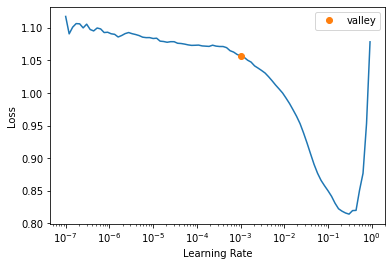

In [21]:
learn.lr_find()

In [22]:
# taux d'apprentissage 
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.468194,0.288325,0.902610,06:25


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.134831,0.182761,0.934522,05:13
1,0.033791,0.164949,0.941728,05:09
2,0.012943,0.178192,0.940809,05:16
3,0.007789,0.193058,0.942298,05:10
4,0.006862,0.196898,0.941324,05:08


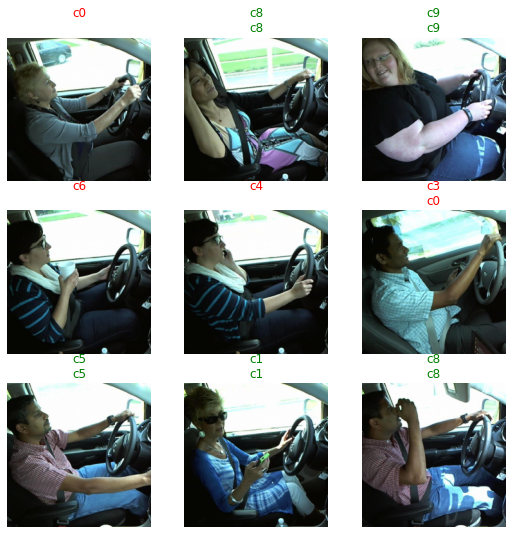

In [23]:
learn.show_results()

<h3 style='color:purple'>Save Model To a File Using Python Pickle</h3>

In [24]:
import pickle
with open('model_pickle_18','wb') as file:
    pickle.dump(learn,file)

<h4 style='color:purple'>Load Saved Model</h4>

In [ ]:
with open('model_pickle_18','rb') as file:
    mp = pickle.load(file)

### Question 5.

Entraînez votre modèle à nouveau jusqu’à la dégradation (forte augmentation) du loss de l’ensemble de validation. Précisez le numéro de l’époque où cette divergence du loss a débuté et la meilleure performance obtenue.


Pour cela nous augmentons le nombre d'époch j'usqua 10 et verifions la loss de validation à l'aide de early stopping.

Nous précisons ensuite le numéro de l'epoch où cette divergence debute c'est à dire où la loss ne diminue plus. 


In [25]:
from fastai.callback.tracker import EarlyStoppingCallback

In [26]:
learn.fit(n_epoch=10, lr=1e-3, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.027317,0.193410,0.937500,05:50
1,0.021422,0.272093,0.921397,05:27
2,0.018630,0.196112,0.941213,05:25


No improvement since epoch 0: early stopping


Après 3 épochs, nous n'avons pas d'amelioration vis a vis de la loss de validation. Nous deduisons un numéro d'époque égale à 3.

### Question 6.
Entraînez de nouveau votre modèle en effectuant des changements de sorte à améliorer la performance du modèle. Il est recommandé de lire la documentation afin de découvrir certaines techniques d’apprentissage améliorant la performance de votre modèle.

Afin d'ameliorer le modèle nous pouvons effectuer certaines transformation sur notre ensemble de données. faire de la data augmentation à l'aide d'operation tel que Rotate, Brightness, Contrast etc. 
Mais nous décidons de rajouter plus de couches en utilisant un model pré-entrainer plus avancé soit le resnet34. 

In [28]:
from fastai.vision import *
from fastai.vision.models import resnet34
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import Resize, aug_transforms


path_data = "drive/MyDrive/conducteur/"
data = ImageDataLoaders.from_df(df[["img", "classname", "is_valid"]], path_data, folder='my_train', valid_col='is_valid', label_delim=' ', item_tfms=Resize(460), batch_tfms=aug_transforms(size=224), seed=2021)


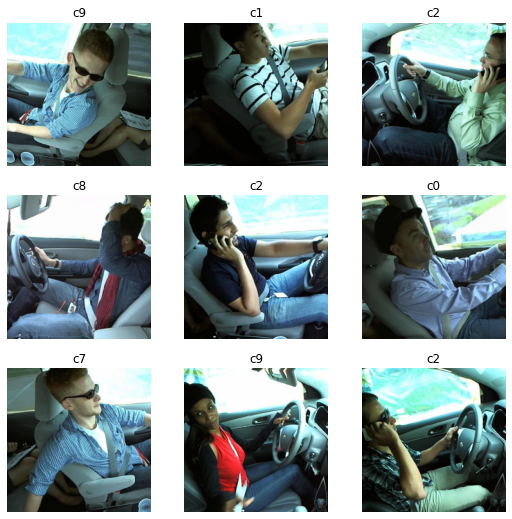

In [29]:
data.show_batch()

In [30]:
from fastai.vision.learner import  cnn_learner
from fastai.vision.all import partial, accuracy_multi

learner_tsf = cnn_learner(data, resnet34, metrics=partial(accuracy_multi, thresh=0.5))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513)

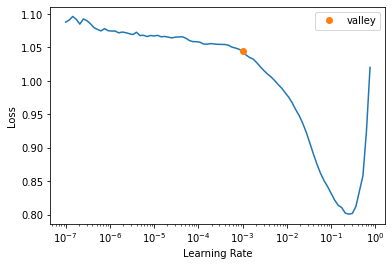

In [31]:
learner_tsf.lr_find()

In [32]:
# taux d'apprentissage trouver a l'aide de la méthode lr_find
learner_tsf.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.463337,0.291585,0.900423,05:26


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.113414,0.160644,0.944191,05:41
1,0.022496,0.145834,0.949504,05:41
2,0.009562,0.143304,0.955055,05:40
3,0.005032,0.152200,0.954118,05:43
4,0.003747,0.151288,0.955386,05:43


In [33]:
# on sauvegarde le model 
with open('model_ameliorer_34','wb') as file:
    pickle.dump(learner_tsf,file)

### Question 7.
Présentez les résultats de votre modèle et critiquez-le.

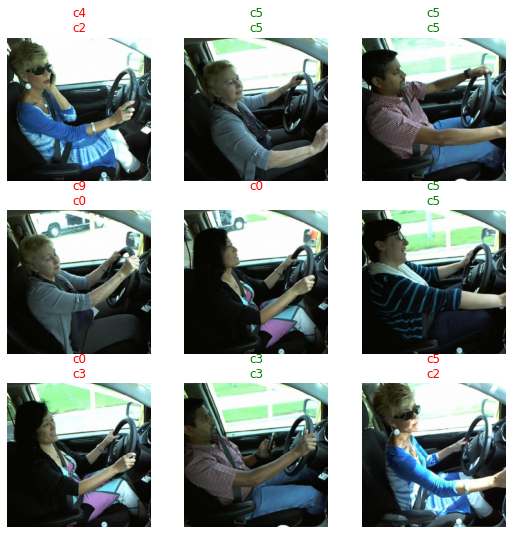

In [34]:
learner_tsf.show_results()

In [39]:
from fastai.vision.learner import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learner_tsf)

Avec une accuracy d'a peu près 0.95 le model peut être considéré comme globalement performant.

On peut observer la matrice de confusion ci-après.

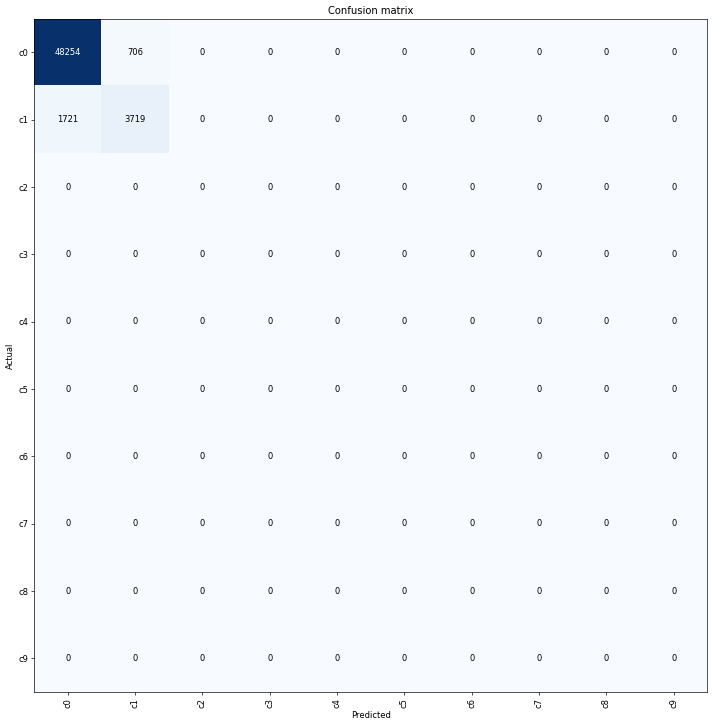

In [40]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Question 8.
À l’aide des outils vus en cours, diagnostiquez 6 prédictions.

In [41]:
interp.most_confused(min_val=3)

[('c1', 'c0', 1721), ('c0', 'c1', 706)]

,target,predicted,probabilities,loss
0,c8,c7,"TensorBase([[3.1180e-04, 5.9349e-05, 1.9079e-04, 1.6806e-04, 1.0547e-04, 6.2254e-05,\n 2.2812e-04, 9.9999e-01, 5.7621e-04, 1.3796e-04],\n [2.4622e-05, 2.6765e-05, 5.4181e-05, 2.4078e-04, 2.1947e-04, 3.6003e-04,\n 3.0686e-04, 3.8567e-05, 5.3062e-05, 9.9954e-01],\n [3.0060e-05, 4.0082e-05, 1.9148e-04, 5.7958e-05, 1.2923e-04, 4.5302e-04,\n 1.3409e-04, 3.5225e-05, 5.9341e-05, 9.9937e-01],\n [8.8818e-04, 2.0089e-04, 1.4513e-03, 9.9952e-01, 1.9767e-04, 4.4419e-04,\n 1.9056e-04, 2.0636e-04, 8.4848e-04, 1.8283e-03],\n [3.0476e-03, 5.5702e-05, 1.9429e-03, 9.9954e-01, 2.6229e-04, 1.3607e-03,\n 2.1771e-04, 1.6187e-04, 1.2023e-03, 1.1874e-03],\n [4.1543e-05, 7.4812e-05, 1.6128e-04, 1.8246e-04, 4.5845e-05, 1.9374e-03,\n 1.7095e-04, 3.8230e-05, 2.0031e-03, 9.9698e-01]])",1.861060380935669


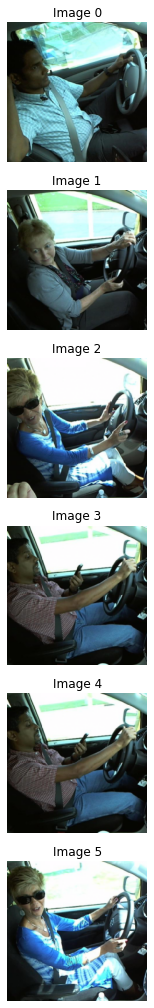

In [44]:
interp.plot_top_losses(6, nrows=6)

In [43]:
interp.print_classification_report()

              precision    recall  f1-score   support

          c0       0.97      0.99      0.98     48960
          c1       0.84      0.68      0.75      5440
          c2       0.00      0.00      0.00         0
          c3       0.00      0.00      0.00         0
          c4       0.00      0.00      0.00         0
          c5       0.00      0.00      0.00         0
          c6       0.00      0.00      0.00         0
          c7       0.00      0.00      0.00         0
          c8       0.00      0.00      0.00         0
          c9       0.00      0.00      0.00         0

   micro avg       0.96      0.96      0.96     54400
   macro avg       0.18      0.17      0.17     54400
weighted avg       0.95      0.96      0.95     54400



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1